# Homework 5: Stochastic gradient algorithms#


Link to homework - http://www.harchaoui.eu/zaid/teaching/nyu/fall2015/cml_hw5.pdf

### 2) Linear Support Vector Machines ###

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

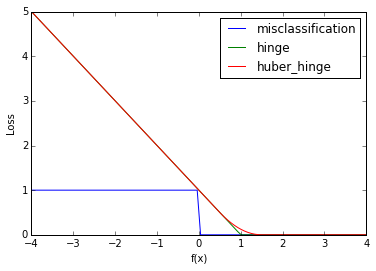

In [36]:
f_x = np.linspace(-4, 4, 100)


def misclassification(f_x):
    return [1 if i <= 0 else 0 for i in f_x ]

def hinge(f_x):
    #consider y (predicted value) = 1
    return [np.max([0, 1-i]) for i in f_x ]

def huber_hinge(f_x):
    #again, y (predicted value) = 1, therefore, yt = f_x
    loss = []
    h = 0.5
    for yt in f_x:
        if yt > 1+h:
            loss.append(0)
        elif abs(1-yt) <= h:
            loss.append(((1+h-yt)**2)/(4*h))
        else:
            loss.append(1-yt)
    return loss

plt.plot(f_x, misclassification(f_x), label = 'misclassification')
plt.plot(f_x, hinge(f_x), label = 'hinge')
plt.plot(f_x, huber_hinge(f_x), label = 'huber_hinge')

plt.legend(loc="upper right")
plt.xlabel("f(x)")
plt.ylabel("Loss")
